# Let's make lots of nice plots across various models

In [1]:
%load_ext autoreload
%autoreload 2
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'

# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [3]:
inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [5]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

import tensorflow as tf

gpu_list = ["/gpu:0", "/gpu:1"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

Number of devices: 2


In [6]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [7]:
pcells_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

In [8]:
pcells_EMB1_flat = pcells_merged['EMB1'].reshape(len(pcells_merged['EMB1']), 128 * 4)

## Make plots for EMB2G EMB1F

In [38]:
varlist = []
cluster_e = pu.rocVar(
    name='clusterE',
    bins=[1,10,50,500],
    df=pdata_merged,
    latex='Cluster E',
    vlist=varlist,
)

In [9]:
model_EMB2G_EMB1F_2 = tf.keras.models.load_model(modelpath+'model_EMB2G_EMB1F_2.h5')
scores_EMB2G_EMB1F_2 = model_EMB2G_EMB1F_2.predict([pcells_EMB2G_channels, pcells_EMB1_flat])

In [20]:
scores_EMB2G_EMB1F_2[:,1].shape

(699858,)

<Figure size 576x432 with 0 Axes>

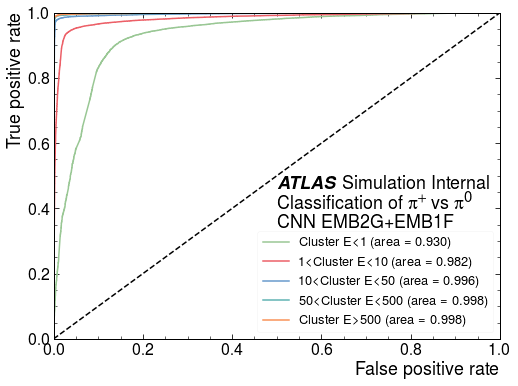

In [42]:
pu.rocScan(varlist, [scores_EMB2G_EMB1F_2[:,1]], ['CNN EMB2G+EMB1F'], plabels, pdata_merged, 
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'},
                        {'x': 0.5, 'y': 0.34, 'text': 'CNN EMB2G+EMB1F'}])

<Figure size 576x432 with 0 Axes>

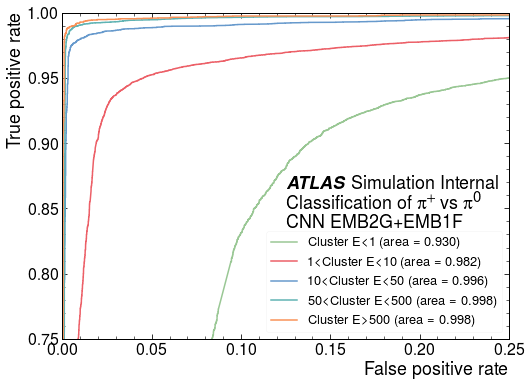

In [43]:
pu.rocScan(varlist, [scores_EMB2G_EMB1F_2[:,1]], ['CNN EMB2G+EMB1F'], plabels, pdata_merged, 
            x_min = 0.0, x_max = 0.25, y_min = 0.75, y_max = 1.0,
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'},
                        {'x': 0.5, 'y': 0.34, 'text': 'CNN EMB2G+EMB1F'}])

/home/mswiatlowski/start_tf/caloml-atlas-new/util/plot_util.py:264: RuntimeWarning: divide by zero encountered in true_divide
  ' (area = {:.3f})'.format(var_auc))
/home/mswiatlowski/start_tf/caloml-atlas-new/util/plot_util.py:264: RuntimeWarning: divide by zero encountered in true_divide
  ' (area = {:.3f})'.format(var_auc))
/home/mswiatlowski/start_tf/caloml-atlas-new/util/plot_util.py:264: RuntimeWarning: divide by zero encountered in true_divide
  ' (area = {:.3f})'.format(var_auc))
/home/mswiatlowski/start_tf/caloml-atlas-new/util/plot_util.py:264: RuntimeWarning: divide by zero encountered in true_divide
  ' (area = {:.3f})'.format(var_auc))
/home/mswiatlowski/start_tf/caloml-atlas-new/util/plot_util.py:264: RuntimeWarning: divide by zero encountered in true_divide
  ' (area = {:.3f})'.format(var_auc))


<Figure size 576x432 with 0 Axes>

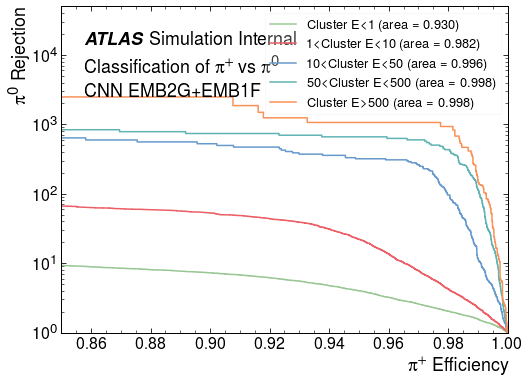

In [80]:
pu.rocScan(varlist, [scores_EMB2G_EMB1F_2[:,1]], ['CNN EMB2G+EMB1F'], plabels, pdata_merged, 
            x_min = 0.85, x_max = 1.0, y_min = 1, y_max = 50000, 
            x_log = False, y_log = True, rejection = True, x_label = '$\pi^{+}$ Efficiency', y_label = '$\pi^{0}$ Rejection',
            atlas_x = 0.05, atlas_y = 0.925, simulation = True,
            textlist = [{'x': 0.05, 'y': 0.8, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'},
                        {'x': 0.05, 'y': 0.725, 'text': 'CNN EMB2G+EMB1F'}])

In [46]:
rocs = pu.buildRocs(varlist, [scores_EMB2G_EMB1F_2[:,1]], ['CNN EMB2G+EMB1F'], plabels, pdata_merged)

In [60]:
for roc in rocs:
    x = rocs[roc]['x']
    y = rocs[roc]['y']

    thresh_index = next(val_y[0] for val_y in enumerate(y) if val_y[1] > 0.95)

    print(thresh_index)
    print(x[thresh_index])
    print(1/x[thresh_index])

    
    

21884
0.24986301369863015
4.00219298245614
11361
0.04533655297313613
22.057256990679097
3270
0.0031358494792249974
318.8928571428571
2962
0.0015152723502671664
659.9473684210526
1202
0.0009402283411685695
1063.5714285714287
